# OMICS PROJECT: ANALYSIS_v4 (Final)


### Files used: 
1. TPM: Transcripts per million file used for the comparison of my hand picked genes (A) bar graph with IL7R and (B) heatmaps.
        omics_aoe23/project/salmon.merged.gene_tpm.tsv
        **callled: rna_matrix_tpm**
        **expressed_genes_tpm**
2. Count Merged used to look differential gene expression 
        omics_aoe23/project/salmon.merged.gene_counts_scaled.tsv
        **called: rna_matrix**
        **expressed_genes
        
### Removing unwanted genes, genes expressed more than once, and in 2 or more samples
1. Sample count: **>0**
    sample_count = (rna_matrix>0).sum(axis=1)
2. Expressed genes: **>2**
    expressed_genes = rna_matrix.loc[sample_count>=2]
    print(f'All genes: {len(rna_matrix)}\nExpressed Genes: {len(expressed_genes)}')


### Type of T test used
ttest_ind




In [2]:
# Data-science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

import warnings
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data

Read in the data using `pandas` just like in Biostats.

In [5]:
# The data is stored centrally
PREFIX = '~/repos/OMICS/projects/aoe23'

### Sample Sheet

In [6]:
sample_sheet = pd.read_csv(f'{PREFIX}/info_sheet.csv')

sample_sheet.head()


,sample,treatment,donor,replicate
0,ada_car_d48,ada,48,2
1,car_d48,control,48,2
2,ada_car_d43,ada,43,1
3,car_d43,control,43,1


In [7]:
# Read the CSV
sample_sheet = pd.read_csv(f'{PREFIX}/info_sheet.csv')

# Clean column names
sample_sheet.columns = sample_sheet.columns.str.strip()

# Enforce order on categorical variables
sample_sheet['treatment'] = pd.Categorical(sample_sheet['treatment'], categories=['ada', 'control'])


# Set 'sample' as the index
sample_sheet.set_index('sample', inplace=True)

# Display the first few rows
print(sample_sheet.head())


            treatment  donor  replicate
sample                                 
ada_car_d48       ada     48          2
car_d48       control     48          2
ada_car_d43       ada     43          1
car_d43       control     43          1


In [9]:
pd.pivot_table(sample_sheet.reset_index(),
               index = 'treatment',
               values = 'sample', aggfunc = 'count')

,sample
treatment,
ada,2
control,2


## Read in Transcriptome: TPM File For Data Visualization


In [10]:
rna_matrix_tpm = pd.read_csv(f'{PREFIX}/salmon.merged.gene_tpm.tsv', sep='\t')
rna_matrix_tpm.columns.name = 'sample_id'
rna_matrix_tpm = rna_matrix_tpm.drop(['gene_id'], axis=1).set_index('gene_name')

rna_matrix_tpm.head()

sample_id,ada_car_d43,ada_car_d48,car_d43,car_d48
gene_name,,,,
TSPAN6,0.000000,0.000000,0.000000,0.000000
TNMD,0.000000,0.000000,0.000000,0.000000
DPM1,38.575232,36.893488,85.582093,58.399814
SCYL3,8.881511,10.178072,8.014066,8.207445
FIRRM,12.032208,12.636945,21.407123,21.200996


### Remove Unusable Rows

One thing to note about RNA-seq is that about half of genes are below the level of detection.

In [11]:
# How many samples is a gene expressed in?
# I am setting the rna_matrix to > 0 because I want to keep all genes that were expressed more than 3 times 
#  Previously Will had all genes that were expressed more than 0 but I wanted to have more of a filter based on feedback from Josh
sample_count = (rna_matrix_tpm>0).sum(axis=1)


Text(0.5, 0, 'Number of Samples')

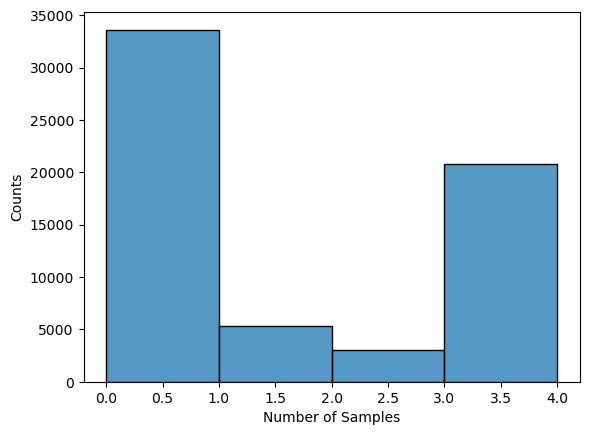

In [12]:
sns.histplot(sample_count, bins = np.arange(5), stat='count')

plt.ylabel("Counts")
plt.xlabel("Number of Samples")

- More than 34,000 genes were not measured even once.
- about 20,000 genes were expressed in all 4 samples
- Having these in will mess up many downstream processes by artifically inflating our gene counts.
- In this case I'm keep all genes expressed (>3 times) in at least 2 samples; this should still allow genes that are only expressed in a single condition to be captured.
- Given that I am comparing 2 replicates between CAR and ADA-CAR I want it to be captured in at least 2 samples! So adjusted below to be >2. 


In [14]:
expressed_genes_tpm = rna_matrix_tpm.loc[sample_count>=2]
print(f'All genes: {len(rna_matrix_tpm)}\nExpressed Genes: {len(expressed_genes_tpm)}')

All genes: 62709
Expressed Genes: 23778


In [15]:
expressed_genes_tpm.head()


sample_id,ada_car_d43,ada_car_d48,car_d43,car_d48
gene_name,,,,
DPM1,38.575232,36.893488,85.582093,58.399814
SCYL3,8.881511,10.178072,8.014066,8.207445
FIRRM,12.032208,12.636945,21.407123,21.200996
FGR,0.768465,0.336872,0.024496,0.340151
CFH,0.197450,0.615211,7.898411,1.107814


## Common Analyses

There are a handful of python libaries we can use.
If you're doing single-cell transcriptomics you should use `scanpy`.
However, it is a bit overkill when you only have a handful of samples.
We'll just use pandas/sklearn/statsmodels.
If you're doing something more in-depth, check out the scanpy tutorials.

### Dimensionality Reduction

This is the process of _projecting_ your data into fewer dimensions for visualization.
This can be useful as an initial screening to understand how samples cluster with each other.

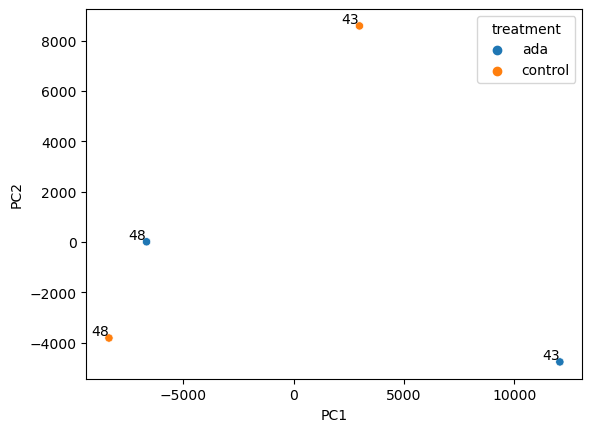

In [16]:
from sklearn.decomposition import PCA

# Project each _sample_ into a smaller dimension

reduced = PCA(n_components=2).fit_transform(expressed_genes_tpm.T)
ax = sns.scatterplot(x = reduced[:,0], y = reduced[:, 1],
                hue = sample_sheet['treatment'])
ax.set_xlabel('PC1'), ax.set_ylabel('PC2')


for i, donor in enumerate(sample_sheet['donor']):
    ax.annotate(donor, (reduced[i, 0], reduced[i, 1]), fontsize=10, color='black', ha='right', va='bottom')




# Result from PCA Plot: Project each _sample_ into a smaller dimension

- The samples of similar conditions should group together.
- However we do not see this as the case.....it could be because we have a really small number of samples and there could be varaiblity between the 2. 
- This is evidence that maybe there isn't a big effect of ADA-1 over expression. Or it could be that the sample size is too low.


### Visualization

Seaborn is the easiest way to visualize the expression of a few genes across different conditions.

Given that the paper claims that the expression of ADA-1 increases stem like phenotype I took a look at IL7R gene expression because it plays a crucial role in T cell development and maintenance of the stem-like state.


Text(0.5, 1.0, 'Expression of IL7R: Key Stemness Marker')

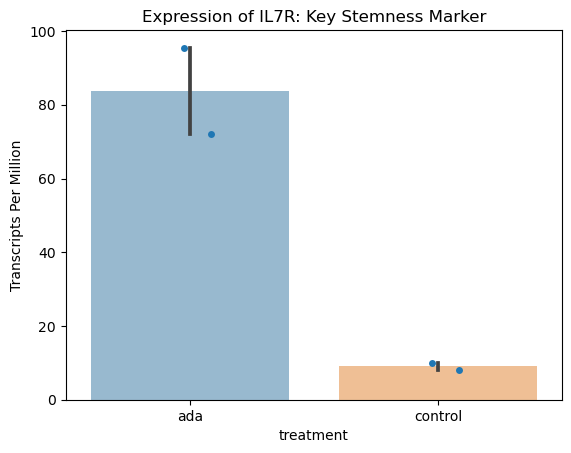

In [17]:
ax = sns.barplot(y = expressed_genes_tpm.loc['IL7R', sample_sheet.index],
                 x = sample_sheet['treatment'], alpha=0.5)


sns.stripplot(y = expressed_genes_tpm.loc['IL7R', sample_sheet.index],
              x = sample_sheet['treatment'], 
              ax=ax)

plt.ylabel("Transcripts Per Million")
plt.title("Expression of IL7R: Key Stemness Marker")

For single gene hypothesis testing, Pingouin is easiest for doing your statistics.

I suggest re-bookmarking the decision trees for each test: https://pingouin-stats.org/build/html/guidelines.html

- Given that I have only 2 samples, for each group--I know that my data is not normally distributed. 
- Below, I fail the normality test and need to use non-parametric tests/ rely on descriptive statistics or qualitative reasoning about the data.

I can use the: **Wilcoxon Signed-Rank Test:**
- Compares two paired (dependent) groups (e.g., before and after treatment).
- Does not assume normality of differences between pairs.
- Equivalent to a paired t-test for non-normal data.


In [ ]:
data = pd.DataFrame({'expression': rna_matrix.loc['IL7R', sample_sheet.index],
                     'treatment': sample_sheet['treatment']})
data.head()



In [59]:
# WILCOXON between treatments


# Split the data into two groups
il7r_ada_group = data[data['treatment'] == 'ada']['expression']
il7r_control_group = data[data['treatment'] == 'control']['expression']

# Perform the Wilcoxon test
il7r_stats = pg.wilcoxon(il7r_ada_group, il7r_control_group)

# Print the result
print(il7r_stats)




          W-val alternative  p-val  RBC  CLES
Wilcoxon    0.0   two-sided    0.5  1.0   1.0


# Heatmaps Comparing Expression of Key Genes of Interest

### Heatmaps Comparing expression of key T Cell exhaustion genes
#####  Note that these were just simply genes I hand picked to take a quick look at 
- CTLA4
- PD1
- LAG3
- HAVCR2 (AKA TIM3)
- TIGIT




In [60]:
## first adjust expressed genes matrix so that I have a z score value for each before making heatmap

## Note that also for the sake of using heat maps I will be using the tpm file instead!!!
from scipy.stats import zscore

# Apply z-score across each row (genes)
expressed_genes_zscore_tpm = expressed_genes_tpm.apply(zscore, axis=1)

# View the transformed matrix
expressed_genes_zscore_tpm.head()

sample_id,ada_car_d43,ada_car_d48,car_d43,car_d48
gene_name,,,,
DPM1,-0.828910,-0.914498,1.563393,0.180015
SCYL3,0.072258,1.602158,-0.951299,-0.723118
FIRRM,-1.066070,-0.931398,1.021686,0.975782
FGR,1.515221,-0.115725,-1.296162,-0.103334
CFH,-0.714464,-0.582236,1.723019,-0.426319


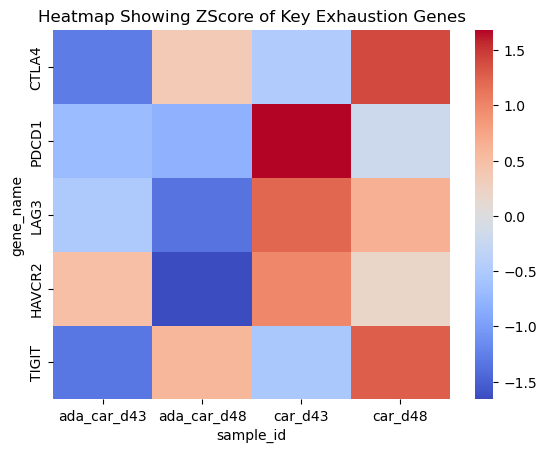

In [63]:
sns.heatmap(expressed_genes_zscore_tpm.loc[['CTLA4', 'PDCD1', 'LAG3', 'HAVCR2', 'TIGIT']], cmap="coolwarm") # Change to coolwarm color


plt.title("Heatmap Showing ZScore of Key Exhaustion Genes")
plt.show()

### Heatmap Comparing expression of genes associated with T cell stemness


- TCF7 (transcription factor 7)
- LEF1 (lymphoid enhancer factor 1)
- IL7R


Text(0.5, 1.0, 'Heatmap Showing ZScore of Key Stemness Genes')

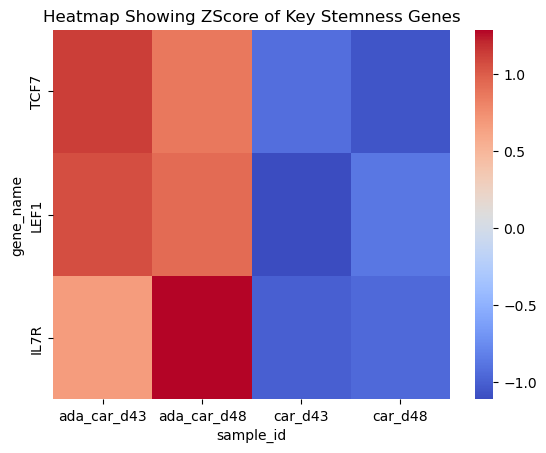

In [64]:
sns.heatmap(expressed_genes_zscore_tpm.loc[['TCF7', 'LEF1', 'IL7R']], cmap="coolwarm")
plt.title("Heatmap Showing ZScore of Key Stemness Genes")

## Pairwise Comparisons

Most pipelines, including [`nfcore`](https://nf-co.re/rnaseq/3.17.0/docs/output/#deseq2), will perform basic pairwise comparisons between test & control groups.
This is usually done with DESeq2, an R package. Yuck.

We can do a similar analysis ourselves.

First I will bring in the transcriptome counts_merged file and get only the expressed genes.

In [76]:
rna_matrix = pd.read_csv(f'{PREFIX}/salmon.merged.gene_counts_scaled.tsv', sep='\t')
rna_matrix.columns.name = 'sample_id'
rna_matrix = rna_matrix.drop(['gene_id'], axis=1).set_index('gene_name')

sample_count = (rna_matrix>4).sum(axis=1)
expressed_genes = rna_matrix.loc[sample_count>=2]
print(f'All genes: {len(rna_matrix)}\nExpressed Genes: {len(expressed_genes)}')

All genes: 62709
Expressed Genes: 19658


In [77]:
## Make a table with just the ada treated


ada = expressed_genes[['ada_car_d43', 'ada_car_d48']] 
ada.head()

sample_id,ada_car_d43,ada_car_d48
gene_name,,
DPM1,987.397636,818.058606
SCYL3,227.337141,225.683714
FIRRM,307.984505,280.205591
FGR,19.670148,7.469639
CFH,5.054063,13.641395


In [78]:
## Make a table with just the control treated
control = expressed_genes[['car_d43', 'car_d48']]  # Adjust based on actual column names for 'control'
control.head()


sample_id,car_d43,car_d48
gene_name,,
DPM1,2000.594989,1127.081955
SCYL3,187.339427,158.398846
FIRRM,500.419907,409.166714
FGR,0.572627,6.564714
CFH,184.635838,21.380157


In [79]:
# Calculate a log2 ratio of the difference in expression

# Calculate the mean expression for each gene across samples in the 'ada' and 'control' groups
ada_mean = ada.mean(axis=1)
control_mean = control.mean(axis=1)
epsilon = 1e-8
# Calculate the log2 ratio of the difference in expression, adding a small constant to the control_mean
log2rc = np.log2((ada_mean + epsilon) / (control_mean + epsilon))

# Print or inspect the results
log2rc.head()


gene_name
DPM1    -0.792728
SCYL3    0.389897
FIRRM   -0.628929
FGR      1.926951
CFH     -3.461997
dtype: float64

In [80]:
# When doing matrix level t-tests, the scipy package is easier.
## note that I adjusted to use ttest_rel instead of ttestind
from scipy.stats import ttest_rel
import pingouin as pg

In [81]:
# Calculate a p-value for each gene


# Perform t-test for each gene
_, pvals = ttest_rel(ada, control, axis=1)  # Use ttest_rel for paired samples

# Convert p-values into a pandas Series with gene names as index
pval_ser = pd.Series(pvals, index=expressed_genes.index)

# Apply Benjamini-Hochberg correction for multiple testing
_, bh_pvals = pg.multicomp(pval_ser, alpha=0.05, method='fdr_bh')

# View corrected p-values
pval_ser.head(), bh_pvals[:5]


(gene_name
 DPM1     0.311538
 SCYL3    0.158561
 FIRRM    0.124132
 FGR      0.469857
 CFH      0.472583
 dtype: float64,
 array([0.61165497, 0.5621196 , 0.55128413, 0.6917387 , 0.69282041]))

In [82]:
## Make a results table with p log2FC, pvals, bhVals and mean expression. 
## first find mean expression by completing the following 


mean_expression = pd.concat([ada, control], axis=1).mean(axis=1)
mean_expression


gene_name
DPM1               1233.283297
SCYL3               199.689782
FIRRM               374.444179
FGR                   8.569282
CFH                  56.177863
                      ...     
ENSG00000293562     822.592223
ENSG00000293574       3.921708
ENSG00000293588       5.148785
ENSG00000293599       7.467447
ENSG00000293600     341.170357
Length: 19658, dtype: float64

In [87]:
## Make a results table with p log2FC, pvals, bhVals and mean expression. 

differential_expression = pd.DataFrame({'log2FC': log2rc,
                            'pvals': pvals,
                            'bh_pvals': bh_pvals,
                            'mean_expression': mean_expression})
differential_expression.head()

,log2FC,pvals,bh_pvals,mean_expression
gene_name,,,,
DPM1,-0.792728,0.311538,0.611655,1233.283297
SCYL3,0.389897,0.158561,0.562120,199.689782
FIRRM,-0.628929,0.124132,0.551284,374.444179
FGR,1.926951,0.469857,0.691739,8.569282
CFH,-3.461997,0.472583,0.692820,56.177863


### Volcano Plot


<AxesSubplot: xlabel='log2FC', ylabel='bh_pvals'>

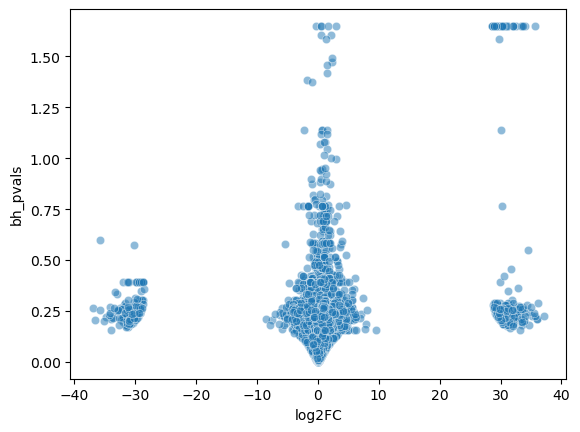

In [89]:
sns.scatterplot(data = differential_expression,
                x = 'log2FC',
                y = -np.log10(differential_expression['bh_pvals']),
                alpha=0.5)

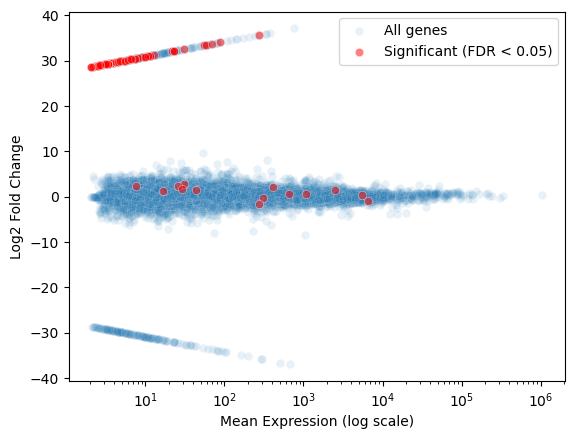

In [90]:
import matplotlib.pyplot as plt

# Base scatterplot for all data points
ax = sns.scatterplot(data=differential_expression,
                     x='mean_expression',
                     y='log2FC',
                     alpha=0.1, label="All genes")

# Highlight significant points in a different color
sns.scatterplot(data=differential_expression[differential_expression['bh_pvals'] < 0.05],
                x='mean_expression',
                y='log2FC',
                alpha=0.5, color='red', label="Significant (FDR < 0.05)")

# Set the x-axis to log scale
ax.set_xscale('log')

# Add axis labels and a legend
ax.set_xlabel('Mean Expression (log scale)')
ax.set_ylabel('Log2 Fold Change')
ax.legend()

# Show the plot
plt.show()

In [103]:
## export CSV for all differentially expressed genes, and only sorting on significantly differentially expressed genes

differential_expression.to_csv('differential_expression.csv', index=True)


In [116]:

# Filter the DataFrame to include only rows where FDR (bh_pvals) < 0.05 and export CSV

sig_differential_expression = differential_expression[differential_expression['bh_pvals'] < 0.05]

sig_differential_expression.to_csv('sig_differential_expression.csv', index=True)
sig_differential_expression.head()


,log2FC,pvals,bh_pvals,mean_expression
gene_name,,,,
ANK1,1.466579,0.000126,0.038006,43.397792
PIGU,-0.246647,0.000039,0.022395,309.337790
SFXN3,0.530418,0.000073,0.024725,664.764617
GOLIM4,-1.723196,0.000139,0.041451,275.724481
PFN1P10,32.029967,0.000064,0.022395,21.925562


In [113]:
## Make a df that only contains the groups where the log2FC is >20 and export CSV

filter_log2fc_high = differential_expression[differential_expression['log2FC'] > 20]

filter_log2fc_high.to_csv('filtered_log2fc_high.csv', index=True)

In [114]:
## Make a df that only contains the groups where log2FC is between -10 and 10 to contain the  middle groups and export CSV


filtered_log2fc_low = differential_expression[(differential_expression['log2FC'] >= -10) & (differential_expression['log2FC'] <= 10)]

# Inspect the resulting DataFrame
filtered_log2fc_low.to_csv('filtered_log2fc_low.csv', index=True)

### Linear Models

Instead of a standard _differential expression_ analysis which performs a standard two-group analysis, this uses a linear regression model.

Because I only have 2 groups I do not have a need for linear models and deleted the rest of the notebook.

### Gene Set Enrichment Analysis
- Now that I have a standard differential expression analysis, I can look to see which pathways may be of interest. 


In [133]:
## EXTRACT THE NAMES of the differentially expressed genes to load to enrichr

genes = pd.DataFrame(differential_expression.index, columns=['gene_name'])
genes.to_csv('genes.csv', index=False)


In [129]:
## sig gene names

sig_genes = pd.DataFrame(sig_differential_expression.index, columns=['gene_name'])
sig_genes.to_csv('genes_sig.csv', index=False)

In [130]:
## high log2fc gene names

highlog_genes = pd.DataFrame(filter_log2fc_high.index, columns=['gene_name'])
highlog_genes.to_csv('genes_high.csv', index=False)

In [132]:
## low log2fc gene names

lowlog_genes = pd.DataFrame(filtered_log2fc_low.index, columns=['gene_name'])
lowlog_genes.to_csv('genes_low.csv', index=False)